In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt
import seaborn as sns


# Load the Excel file
file_path = "GP25_Business-Case-Marketing Data Science Specialist.xlsx"
df = pd.read_excel(file_path, sheet_name='Data', engine="openpyxl")

# Convert YEAR_WEEK to a proper date (ISO Week format)
df["DATE"] = pd.to_datetime(df["DATE"], origin="1899-12-30", unit="D")  # Convert Excel serial date

# Drop YEAR_WEEK & PERIOD since DATE represents the time variable
df.drop(columns=["YEAR_WEEK", "PERIOD"], inplace=True)

In [10]:
# Define target variable
y = df["RED_BULL_sales_litres"]

# Define independent variables (potential drivers)
features = [
    "RED_BULL_DWD", "RED_BULL_price", "RED_BULL_pct_vol_promo", "RED_BULL_vol_deal",
    "COMPETITOR_sales_litres", "COMPETITOR_DWD", "COMPETITOR_price",
    "COMPETITOR_pct_vol_promo", "COMPETITOR_vol_deal",
    "ConsAct_Total", "CANS_SAMPLED_PRODUCTHIERARCHY", "CANS_SEEDED_PRODUCTHIERARCHY",
    "paid_grp_tv", "paid_imp_disp", "paid_imp_sem", "paid_imp_social",
    "paid_imp_webtv", "paid_spend_cinema", "paid_spend_ooh",
    "paid_imp_social_camp1", "paid_imp_social_camp2", "paid_imp_social_camp3",
    "paid_imp_social_camp4", "paid_imp_social_camp5",
    "paid_imp_webtv_camp1", "paid_imp_webtv_camp2", "paid_imp_webtv_camp3",
    "Earned_sports_athletes_contacts", "Earned_motorsports_athletes_contacts",
    "managed_engvdv_culture", "managed_engvdv_motorsports", "managed_engvdv_sports",
    "owned_sessions"
]
X = df[features]

In [11]:
# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardise features (important for Ridge regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/Users/shahrez/miniconda3/envs/redbull/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


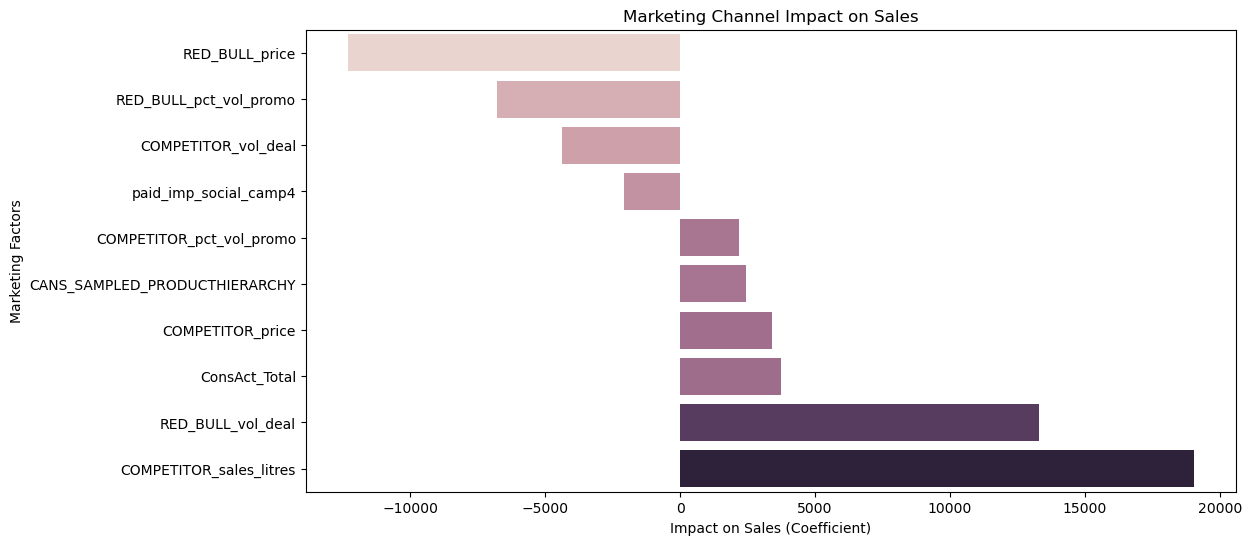

In [36]:
# Ridge regression with cross-validation
ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), store_cv_values=True)
ridge.fit(X_train_scaled, y_train)

# Extract coefficients
coefficients = pd.DataFrame({
    "Feature": features,
    "Coefficient": ridge.coef_
}).sort_values(by="Coefficient")

# Filter out low-impact features
filtered_coefficients = coefficients[coefficients["Coefficient"].abs() > 2000]

# Sort by impact
filtered_coefficients = filtered_coefficients.sort_values(by="Coefficient")

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(
    data=filtered_coefficients,
    x="Coefficient",
    y="Feature",
    hue="Coefficient",
    legend=False  # Disable legend
)
plt.xlabel("Impact on Sales (Coefficient)")
plt.ylabel("Marketing Factors")
plt.title("Marketing Channel Impact on Sales")
plt.show()

In [ ]:
# Model evaluation
r2_score = ridge.score(X_test_scaled, y_test)
print(f"Model R²: {r2_score:.4f}")


Model R²: 0.8952


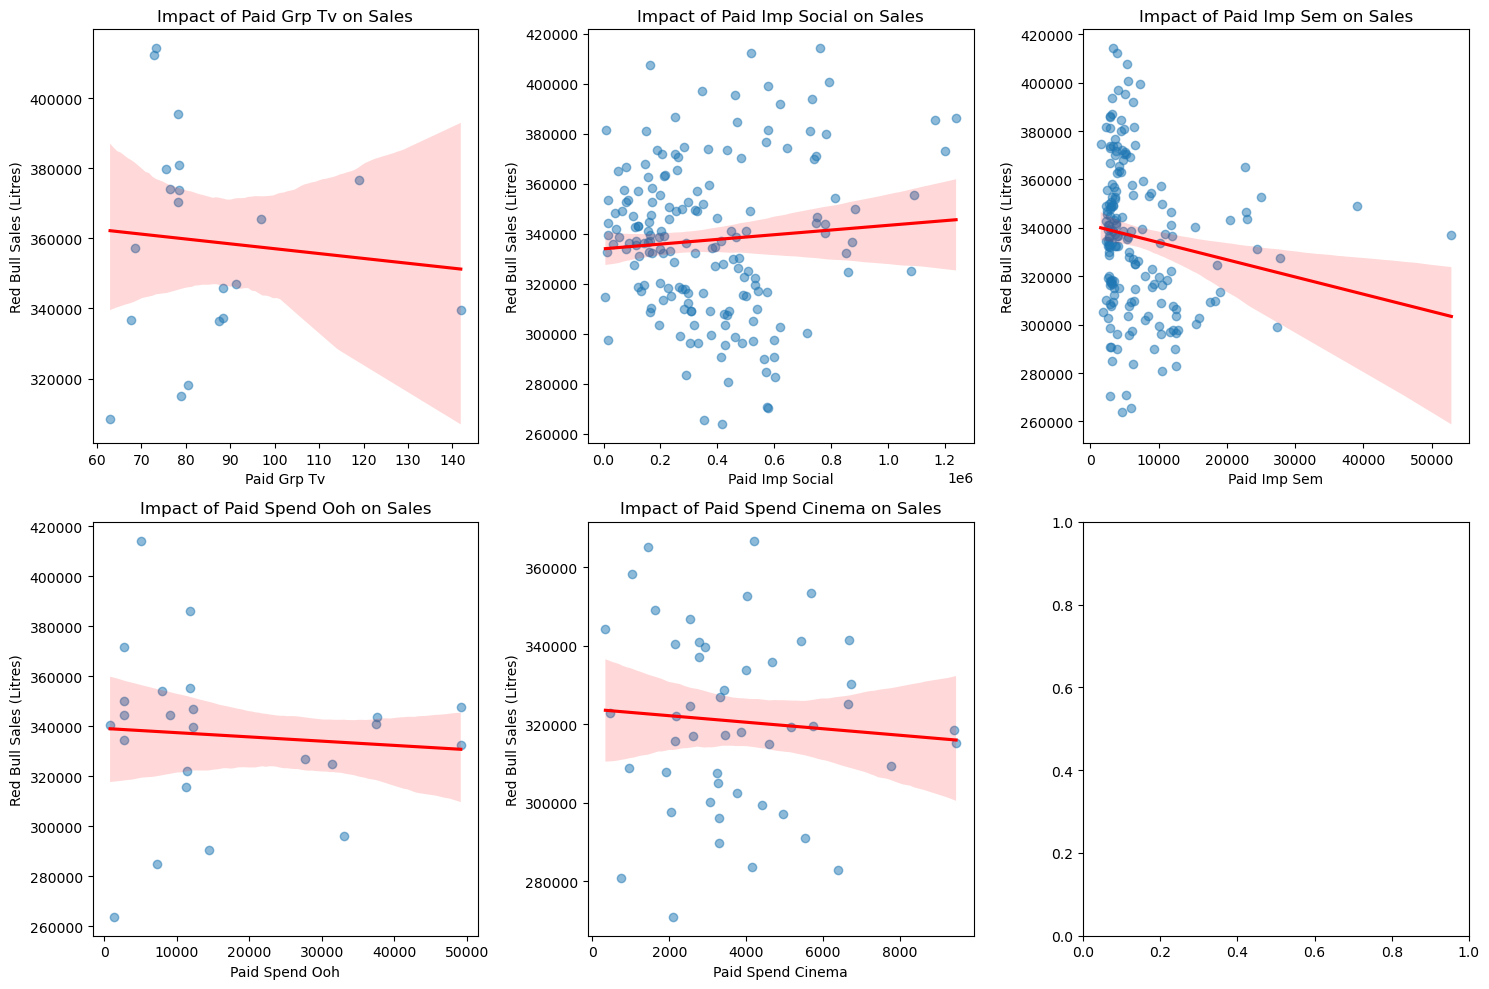

In [16]:
paid_media_features = ["paid_grp_tv", "paid_imp_social", "paid_imp_sem", "paid_spend_ooh", "paid_spend_cinema"]


fig, axes = plt.subplots(2, 3, figsize=(15, 10))



for ax, feature in zip(axes.flatten(), paid_media_features):
    df_filtered = df[df[feature] > 0]
    sns.regplot(data=df_filtered, x=feature, y="RED_BULL_sales_litres", scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ax=ax)
    ax.set_title(f"Impact of {feature.replace('_', ' ').title()} on Sales")
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel("Red Bull Sales (Litres)")

plt.tight_layout()
plt.show()

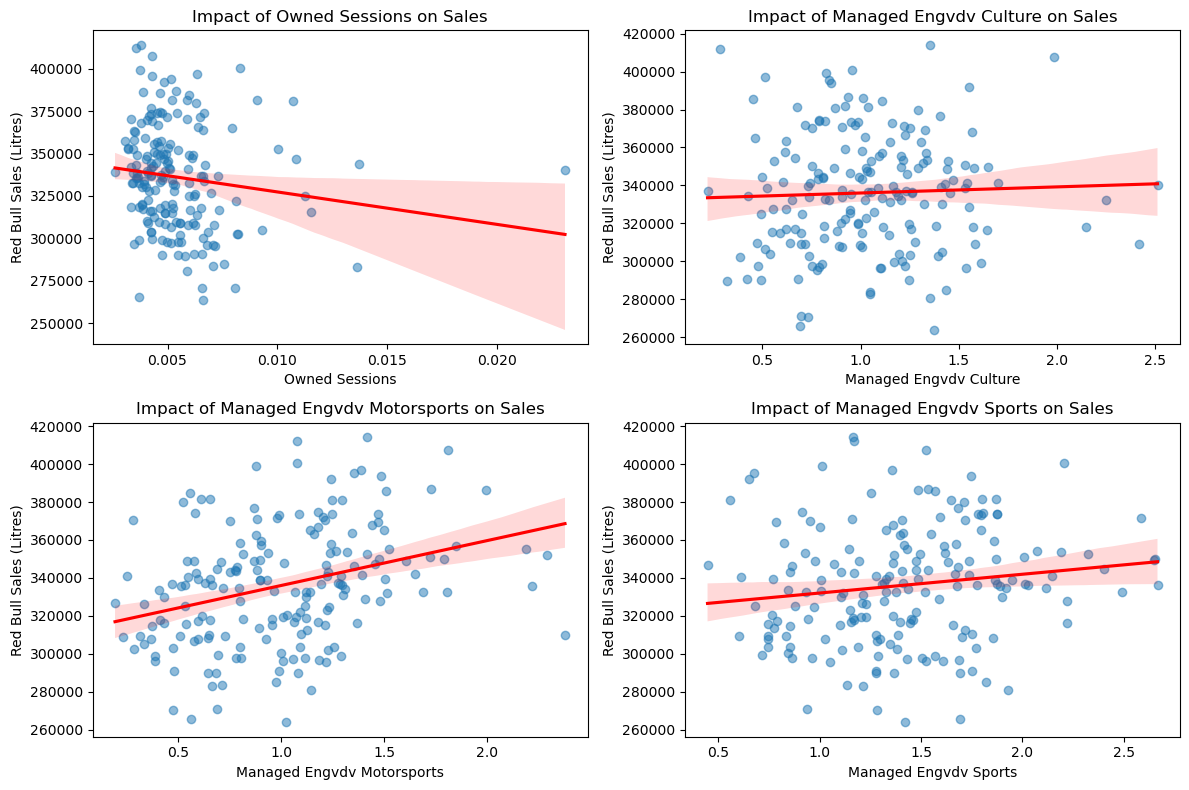

In [17]:
owned_media_features = ["owned_sessions", "managed_engvdv_culture", "managed_engvdv_motorsports", "managed_engvdv_sports"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, feature in zip(axes.flatten(), owned_media_features):
    sns.regplot(data=df, x=feature, y="RED_BULL_sales_litres", scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ax=ax)
    ax.set_title(f"Impact of {feature.replace('_', ' ').title()} on Sales")
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel("Red Bull Sales (Litres)")

plt.tight_layout()
plt.show()

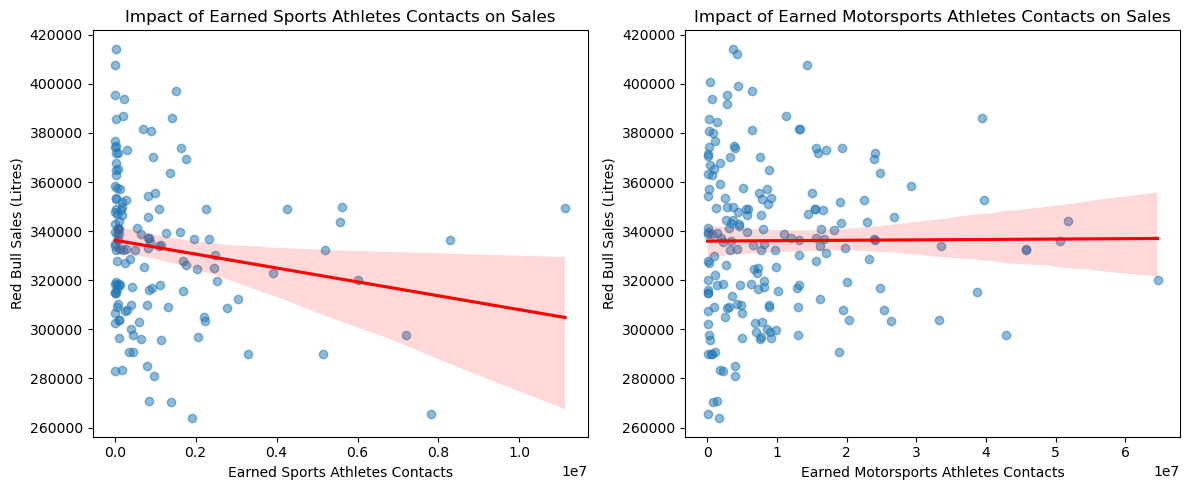

In [21]:
earned_media_features = ["Earned_sports_athletes_contacts", "Earned_motorsports_athletes_contacts"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, feature in zip(axes.flatten(), earned_media_features):
    df_filtered = df[df[feature] > 1.0]
    sns.regplot(data=df_filtered, x=feature, y="RED_BULL_sales_litres", scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ax=ax)
    ax.set_title(f"Impact of {feature.replace('_', ' ').title()} on Sales")
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel("Red Bull Sales (Litres)")

plt.tight_layout()
plt.show()

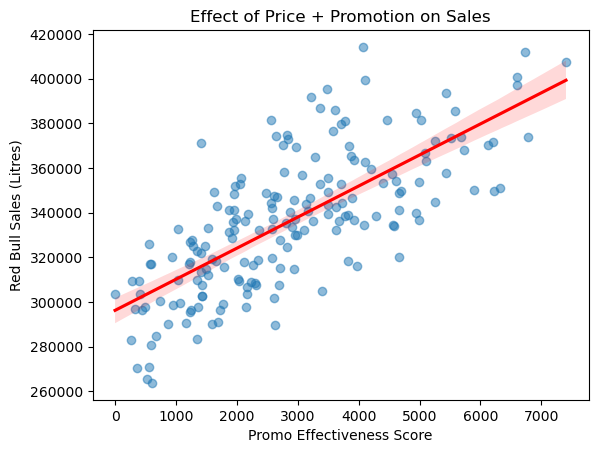

In [22]:
df["promo_effectiveness"] = df["RED_BULL_vol_deal"] * (1 - df["RED_BULL_price"] / df["RED_BULL_price"].max())

sns.regplot(data=df, x="promo_effectiveness", y="RED_BULL_sales_litres", scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.title("Effect of Price + Promotion on Sales")
plt.xlabel("Promo Effectiveness Score")
plt.ylabel("Red Bull Sales (Litres)")
plt.show()

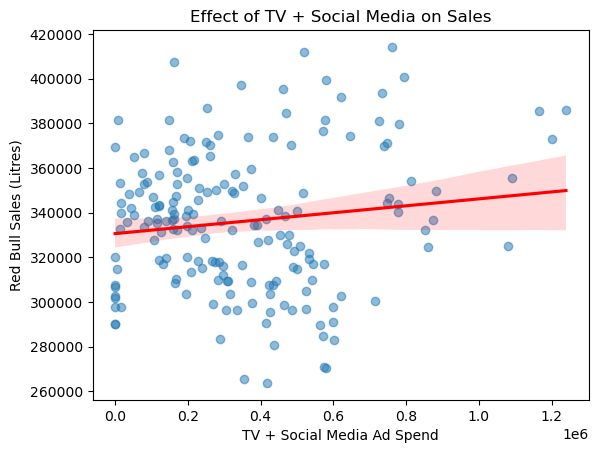

In [23]:
df["tv_social_combined"] = df["paid_grp_tv"] + df["paid_imp_social"]

sns.regplot(data=df, x="tv_social_combined", y="RED_BULL_sales_litres", scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.title("Effect of TV + Social Media on Sales")
plt.xlabel("TV + Social Media Ad Spend")
plt.ylabel("Red Bull Sales (Litres)")
plt.show()

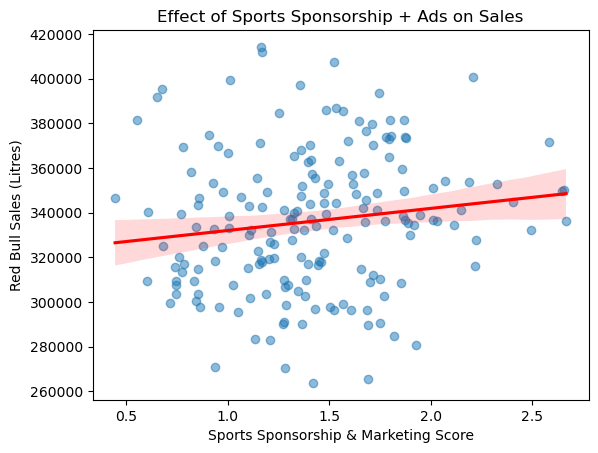

In [26]:
df["sports_marketing"] = df["managed_engvdv_sports"]

sns.regplot(data=df, x="sports_marketing", y="RED_BULL_sales_litres", scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.title("Effect of Sports Sponsorship + Ads on Sales")
plt.xlabel("Sports Sponsorship & Marketing Score")
plt.ylabel("Red Bull Sales (Litres)")
plt.show()

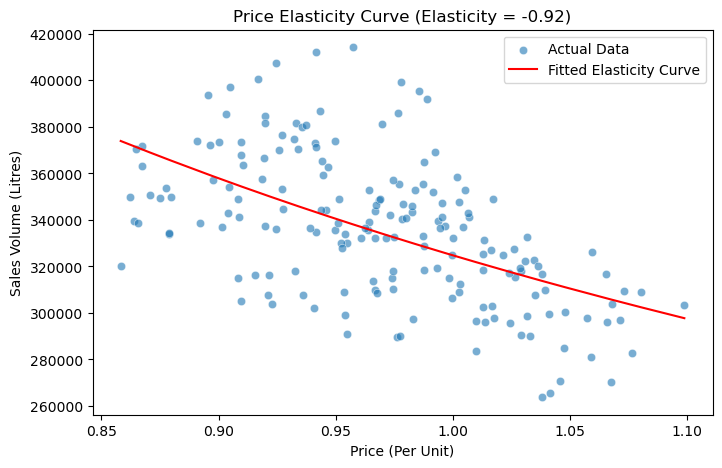

In [27]:
import statsmodels.api as sm

# Drop zero values in price to avoid log(0) errors
df_filtered = df[df["RED_BULL_price"] > 0].copy()

# Log transformation for elasticity estimation
df_filtered["log_price"] = np.log(df_filtered["RED_BULL_price"])
df_filtered["log_sales"] = np.log(df_filtered["RED_BULL_sales_litres"])

# Fit a linear regression model on log-transformed variables
X = sm.add_constant(df_filtered["log_price"])  # Add constant for intercept
y = df_filtered["log_sales"]
model = sm.OLS(y, X).fit()

# Generate predicted values
df_filtered["predicted_sales"] = model.predict(X)

# Plot Price Elasticity Curve
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_filtered["RED_BULL_price"], y=df_filtered["RED_BULL_sales_litres"], alpha=0.6, label="Actual Data")
sns.lineplot(x=df_filtered["RED_BULL_price"], y=np.exp(df_filtered["predicted_sales"]), color="red", label="Fitted Elasticity Curve")

plt.xlabel("Price (Per Unit)")
plt.ylabel("Sales Volume (Litres)")
plt.title(f"Price Elasticity Curve (Elasticity = {round(model.params['log_price'], 2)})")
plt.legend()
plt.show()

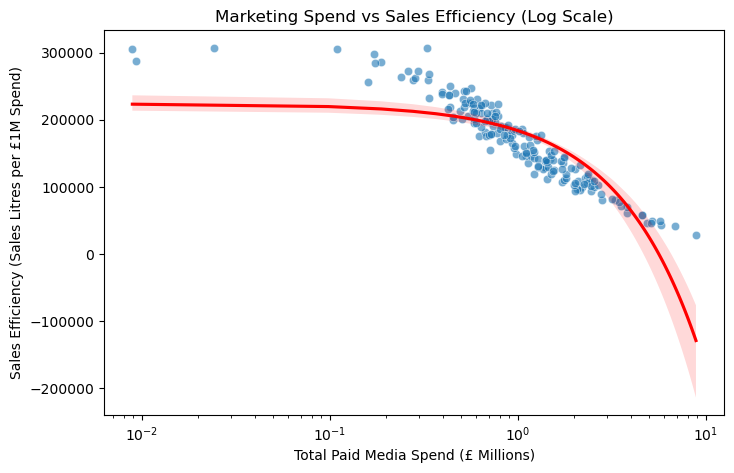

In [34]:

# Define all relevant paid media spend features
paid_media_features = [
    "paid_grp_tv", "paid_imp_social", "paid_imp_sem", "paid_spend_ooh", "paid_spend_cinema",
    "paid_imp_social_camp1", "paid_imp_social_camp2", "paid_imp_social_camp3", 
    "paid_imp_social_camp4", "paid_imp_social_camp5",
    "paid_imp_webtv_camp1", "paid_imp_webtv_camp2", "paid_imp_webtv_camp3"
]

# Compute Total Paid Spend (Convert to Millions for better scaling)
df["Total_Paid_Spend_M"] = df[paid_media_features].sum(axis=1) / 1e6

# Avoid division by zero and scale efficiency per £1M spend
df["Marketing_Efficiency_per_Million"] = df["RED_BULL_sales_litres"] / (df["Total_Paid_Spend_M"] + 1)

# Scatter plot with log scale
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Total_Paid_Spend_M"], y=df["Marketing_Efficiency_per_Million"], alpha=0.6)
sns.regplot(x=df["Total_Paid_Spend_M"], y=df["Marketing_Efficiency_per_Million"], scatter=False, color="red")  # Trend line

plt.xscale("log")  # Apply log scale to Total Spend
plt.xlabel("Total Paid Media Spend (£ Millions)")
plt.ylabel("Sales Efficiency (Sales Litres per £1M Spend)")
plt.title("Marketing Spend vs Sales Efficiency (Log Scale)")
plt.show()

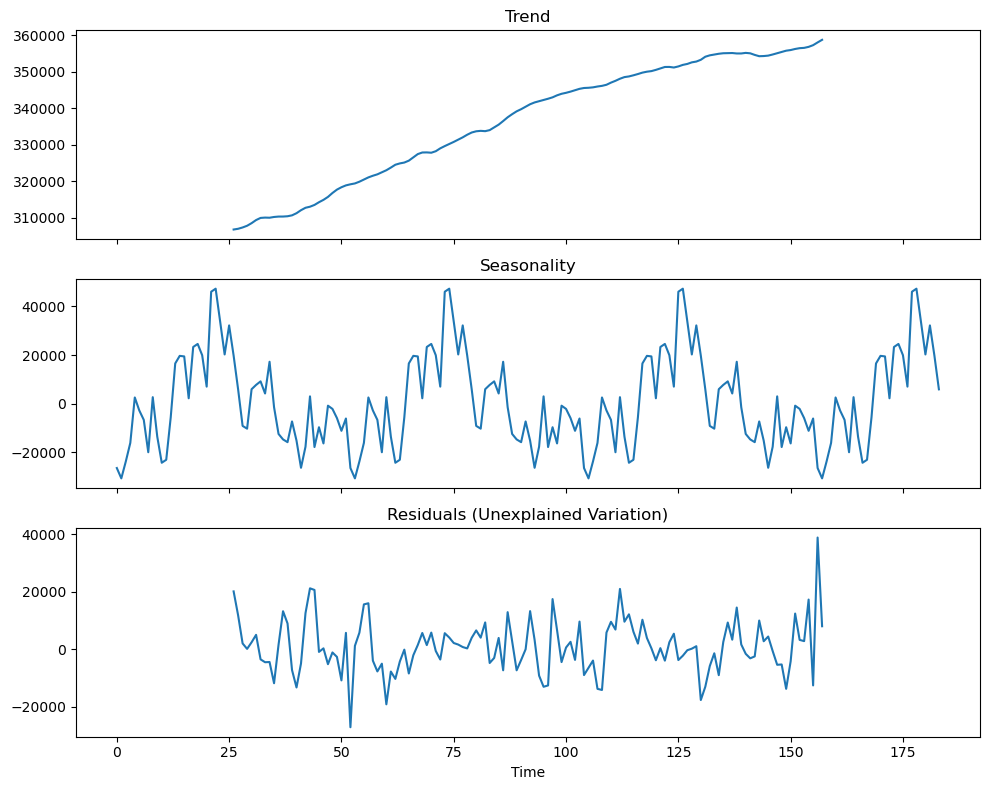

In [30]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure data is in datetime format

# Decompose sales time series
decomposition = seasonal_decompose(df["RED_BULL_sales_litres"], model="additive", period=52)  # Assuming weekly data

# Plot decomposition
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
decomposition.trend.plot(ax=axes[0], title="Trend")
decomposition.seasonal.plot(ax=axes[1], title="Seasonality")
decomposition.resid.plot(ax=axes[2], title="Residuals (Unexplained Variation)")

plt.xlabel("Time")
plt.tight_layout()
plt.show()